# Подключаем необходимые библиотеки

In [3]:
!pip install tqdm --quiet
!pip install scikit-learn --quiet
!pip install catboost --no-cache-dir --quiet
!pip install torch --quiet
!pip install -U lightautoml --quiet

In [24]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
import catboost as cb
import os, shutil, pickle
from collections import defaultdict
import torch
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task
from datetime import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Загрузка и обработка данных

In [5]:
df = pd.read_csv('personal_transactions_data.csv', names=['date', 'description', 'sum', 'tr', 'cat', 'name'], sep=",")
df = df[1:]
df = df[df['tr'] == 'debit']
df = df[['date', 'sum']]
df['sum'] = df['sum'].astype('float')
df

,date,sum
1,01/01/2018,11.11
2,01/02/2018,1247.44
3,01/02/2018,24.22
5,01/04/2018,11.76
6,01/05/2018,25.85
...,...,...
799,09/23/2019,24.63
801,09/28/2019,33.46
802,09/28/2019,4.27
803,09/30/2019,1.75


In [6]:
def prepoc(df):
    df = df[df['date'].notna()]
    df = df[df['sum'].notna()]
    df['date'] = pd.to_datetime(df['date'])
    
    return df
df = prepoc(df)
df

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1247.44
3,2018-01-02,24.22
5,2018-01-04,11.76
6,2018-01-05,25.85
...,...,...
799,2019-09-23,24.63
801,2019-09-28,33.46
802,2019-09-28,4.27
803,2019-09-30,1.75


In [7]:
df_sum = df.copy()
last = ''
for i, row in df.iterrows():
    if row['date'] != last:
        df_sum.loc[(df_sum['date'] ==  row['date']), 'sum'] = sum(df[df['date'] == row['date']]['sum'])
        last = row['date']
#df_sum = df_sum.drop_duplicates()
df_sum.index = [i for i in range(1, 1+df_sum.shape[0])]
#df_sum = df_sum[df_sum['sum'] <1400 ]
df_sum

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1271.66
3,2018-01-02,1271.66
4,2018-01-04,11.76
5,2018-01-05,25.85
...,...,...
682,2019-09-23,61.77
683,2019-09-28,37.73
684,2019-09-28,37.73
685,2019-09-30,76.75


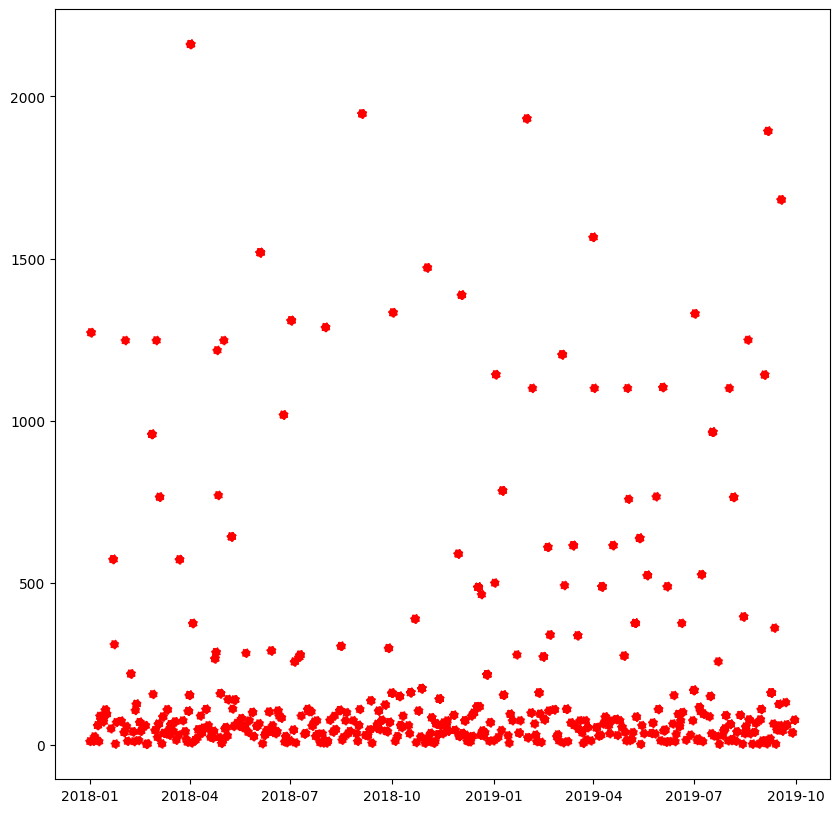

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(df_sum['date'], df_sum['sum'], c="red", linestyle="dotted")
plt.show()

In [9]:
df_diff = df.copy()
df_diff['sum'] = df['sum'].diff()
df_diff['sum'][1] = df['sum'][1]
df_diff

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1236.33
3,2018-01-02,-1223.22
5,2018-01-04,-12.46
6,2018-01-05,14.09
...,...,...
799,2019-09-23,-3.08
801,2019-09-28,8.83
802,2019-09-28,-29.19
803,2019-09-30,-2.52


# Обучение

In [10]:
def make_features(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] > 4).astype('int16')
    
    df['is_winter'] = ((df['month'] >=12) & (df['month'] <= 2)).astype('int16')
    df['is_spring'] = ((df['month'] > 2) & (df['month'] <= 5)).astype('int16')
    df['is_summer'] = ((df['month'] > 5) & (df['month'] <= 8)).astype('int16')
    df['is_autumn'] = ((df['month'] > 8) & (df['month'] <= 11)).astype('int16')
    
    
    #return df.drop(columns=['date'])
    return df

In [11]:
ft = prepoc(df_sum)
display(ft)

,date,sum
1,2018-01-01,11.11
2,2018-01-02,1271.66
3,2018-01-02,1271.66
4,2018-01-04,11.76
5,2018-01-05,25.85
...,...,...
682,2019-09-23,61.77
683,2019-09-28,37.73
684,2019-09-28,37.73
685,2019-09-30,76.75


In [12]:
RANDOM_SEED = 5
EARLY_STOPPING_ROUND = 100

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(ft[['date', 'sum']], ft['sum'], test_size=0.2, shuffle=False)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
X_train = make_features(X_train)
X_eval = make_features(X_eval)
X_valid = make_features(X_valid)
display(X_train)

,date,sum,day,month,day_of_week,is_weekend,is_winter,is_spring,is_summer,is_autumn
1,2018-01-01,11.11,1,1,0,0,0,0,0,0
2,2018-01-02,1271.66,2,1,1,0,0,0,0,0
3,2018-01-02,1271.66,2,1,1,0,0,0,0,0
4,2018-01-04,11.76,4,1,3,0,0,0,0,0
5,2018-01-05,25.85,5,1,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
489,2019-03-23,5.20,23,3,5,1,0,1,0,0
490,2019-03-25,75.00,25,3,0,0,0,1,0,0
491,2019-03-26,16.04,26,3,1,0,0,1,0,0
492,2019-03-27,54.09,27,3,2,0,0,1,0,0


In [15]:
# выделим категориальные фичи для катбуста
CAT_COLUMNS = ['day', 'month', 'day_of_week', 'is_weekend', 'is_winter', 'is_spring', 'is_summer', 'is_autumn']

In [48]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 1, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise' #дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь. 
    param['iterations'] = 100 # максимальное количество построенных деревьев
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter' # детектор переобучения: если кол-во итераций посли оптимального > od_wait, то модель переобучена
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent' # детализация вывода
    cat_features=CAT_COLUMNS
    
    regressor = cb.CatBoostRegressor(**param)

    regressor.fit(X_train.copy().drop(columns=['date', 'sum']), y_train.copy(),
                  eval_set=[(X_eval.copy().drop(columns=['date', 'sum']), y_eval.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy().drop(columns=['date', 'sum'])), squared=False)
    return loss
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=24000, show_progress_bar=False)

In [49]:
study.best_params

{'learning_rate': 0.011,
 'depth': 7,
 'l2_leaf_reg': 1.0,
 'min_child_samples': 4}

In [50]:
try:
    os.mkdir(f"models") # создаем папку для сохранения моделей
except:
    pass

In [51]:
optimized_regressor = cb.CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth=study.best_params['depth'],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        grow_policy='Depthwise',
                                        iterations=100,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=RANDOM_SEED,
                                        logging_level='Silent',
                                       cat_features=CAT_COLUMNS)
optimized_regressor.fit(X_train.copy().drop(columns=['date', 'sum']), y_train.copy(),
                        eval_set=[(X_eval.copy().drop(columns=['date', 'sum']), y_eval.copy())],
                        early_stopping_rounds=EARLY_STOPPING_ROUND)
pred_train = optimized_regressor.predict(X_train.copy().drop(columns=['date', 'sum']))
pred_valid = optimized_regressor.predict(X_valid.copy().drop(columns=['date', 'sum']))
scores_catboost = mean_squared_error(y_valid, pred_valid, squared=False)
with open(f"models/model_catboost.pkl", 'wb') as f:
        pickle.dump(optimized_regressor, f)

In [52]:
scores_catboost

405.4024900218071

In [27]:
# параметры для lama
N_THREADS = 40
N_FOLDS = 3
RANDOM_STATE = 56
TEST_SIZE = 0.2
TIMEOUT = 60*2


np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

task = Task('reg')

In [36]:
# функция для обучения и подсчета метрики lama
def fit_predict_lama(X_train, y_train, X_val, y_val):
    TARGET_NAME = 'sum'
    roles = {
        'target': TARGET_NAME,
    }
    automl = TabularUtilizedAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE})
    oof_pred = automl.fit_predict(X_train, roles=roles, verbose=False)
    preds = automl.predict(X_val)
    score = mean_squared_error(y_val, preds.data[:, 0], squared=False)
    with open(f"models/model_lama.pkl", 'wb') as f:
        pickle.dump(automl, f)
    return [score, preds]

In [37]:
[scores_lama, predict_lama] = fit_predict_lama(X_train.copy(), y_train.copy(), X_valid.copy(), y_valid.copy())

In [38]:
scores_lama

392.72425726963365

# Предсказание

In [53]:
def make_features(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] > 4).astype('int16')
    
    df['is_winter'] = ((df['month'] >=12) & (df['month'] <= 2)).astype('int16')
    df['is_spring'] = ((df['month'] > 2) & (df['month'] <= 5)).astype('int16')
    df['is_summer'] = ((df['month'] > 5) & (df['month'] <= 8)).astype('int16')
    df['is_autumn'] = ((df['month'] > 8) & (df['month'] <= 11)).astype('int16')  
    
    #return df.drop(columns=['date'])
    return df

In [54]:
def make_preds(df, y, model_dir):
    res = dict()
    res['sum'] = df['sum']
    res['date'] = df['date']
    targets = os.listdir(model_dir)
    good_df = df.copy()
    display(good_df)
    for target in targets:
        if target == 'model_catboost.pkl':
            model = [pickle.load(open(f"{model_dir}/{target}", 'rb'))][0]
            preds = model.predict(good_df.drop(columns=['date', 'sum']))
            res[target] = preds
        elif target == 'model_lama.pkl':
            model = [pickle.load(open(f"{model_dir}/{target}", 'rb'))][0]
            preds = model.predict(good_df.drop(columns=['sum']))
            res[target] = preds.data[:, 0]
    return pd.DataFrame(res)

res = make_preds(X_valid, y_valid, 'models')
res

,date,sum,day,month,day_of_week,is_weekend,is_winter,is_spring,is_summer,is_autumn
549,2019-05-24,35.96,24,5,4,0,0,1,0,0
550,2019-05-24,35.96,24,5,4,0,0,1,0,0
551,2019-05-25,67.75,25,5,5,1,0,1,0,0
552,2019-05-25,67.75,25,5,5,1,0,1,0,0
553,2019-05-27,34.33,27,5,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
682,2019-09-23,61.77,23,9,0,0,0,0,0,1
683,2019-09-28,37.73,28,9,5,1,0,0,0,1
684,2019-09-28,37.73,28,9,5,1,0,0,0,1
685,2019-09-30,76.75,30,9,0,0,0,0,0,1


,sum,date,model_catboost.pkl,model_lama.pkl
549,35.96,2019-05-24,178.617414,168.787918
550,35.96,2019-05-24,178.617414,168.787918
551,67.75,2019-05-25,210.228859,70.828156
552,67.75,2019-05-25,210.228859,70.828156
553,34.33,2019-05-27,183.868513,137.767578
...,...,...,...,...
682,61.77,2019-09-23,207.320646,175.311829
683,37.73,2019-09-28,127.222163,124.786629
684,37.73,2019-09-28,127.222163,124.786629
685,76.75,2019-09-30,178.939803,205.835358


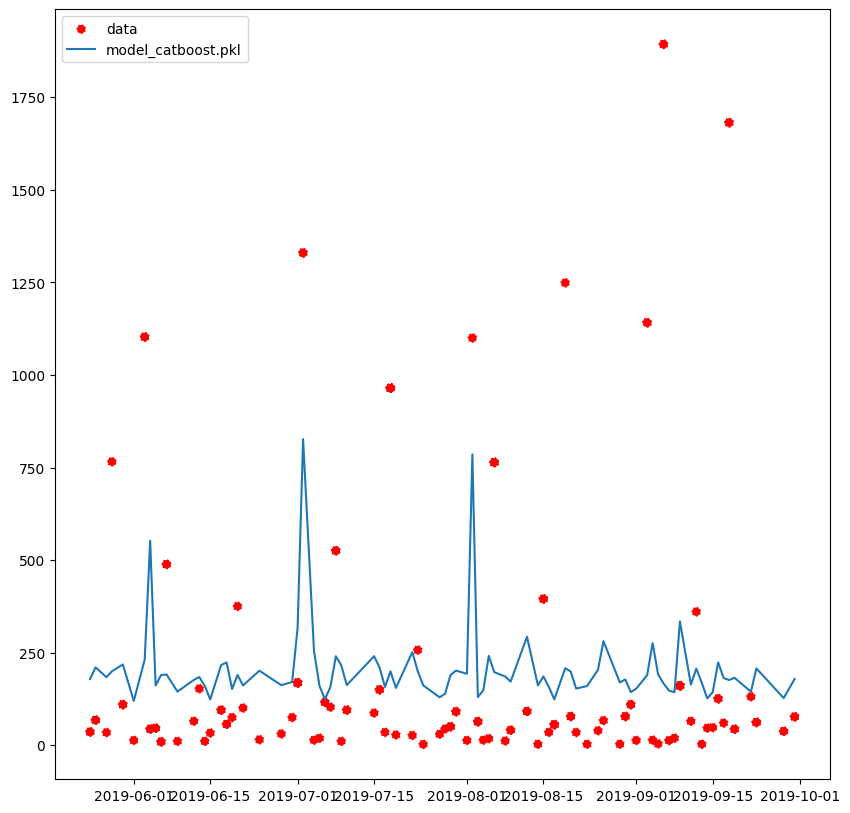

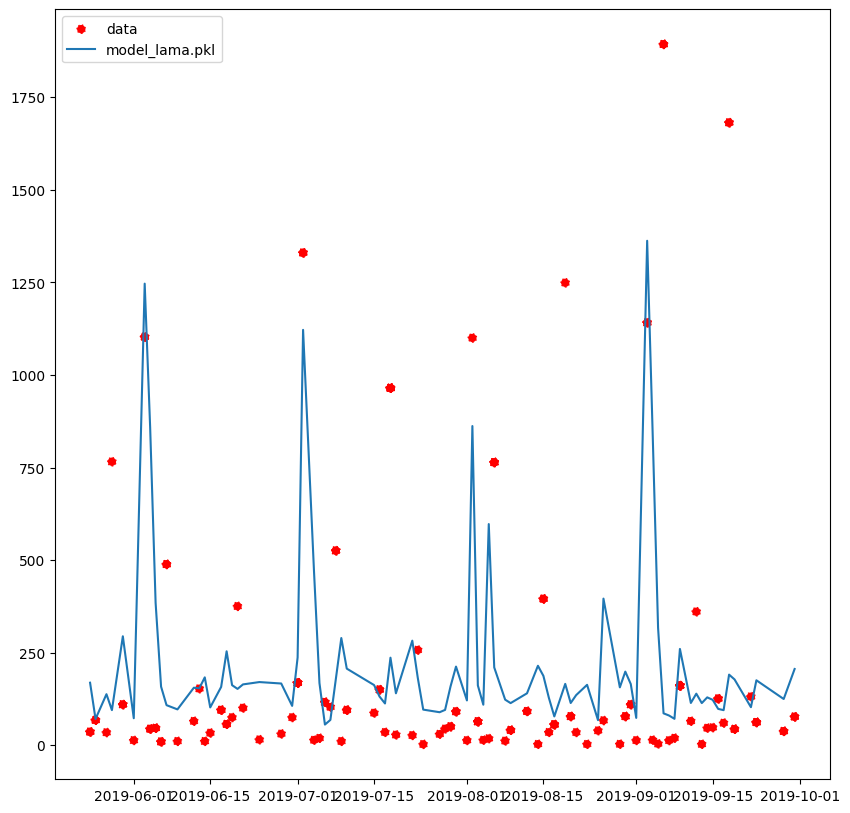

In [57]:
targets = os.listdir('models')
for target in targets:
    plt.figure(figsize=(10,10))
    plt.scatter(res['date'], res['sum'], c="red", linestyle="dotted")
    plt.plot(res['date'], res[target])
    plt.legend(['data', target])
    plt.show()